Задание
 - Считать изображение цитологического мазка крови (blood.jpg).
 - Привести к полутоновому формату и провести бинаризацию, предварительно визуально оценив подходящий метод.
 - Выполнить инверсию бинарного изображения
 - Применить морфологическую обработку для устранения посторонних объектов, заполнения разрывов в контурах
 - Выполнить выделение границ с помощью детектора Canny
 - Выполнить сегментацию клеток крови (выбрать подходящий алгоритм сегментации)
 - Визуализировать метки сегментации на исходном изображении

In [1]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import skimage

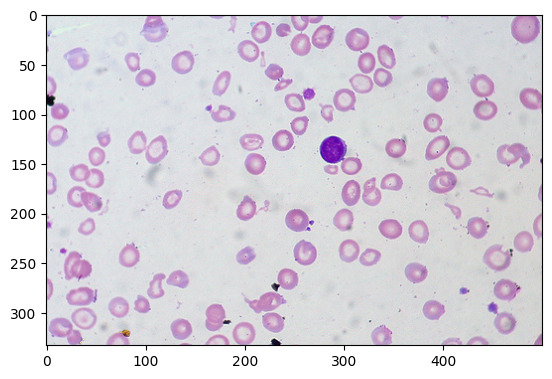

In [6]:
img = cv2.imread('blood.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

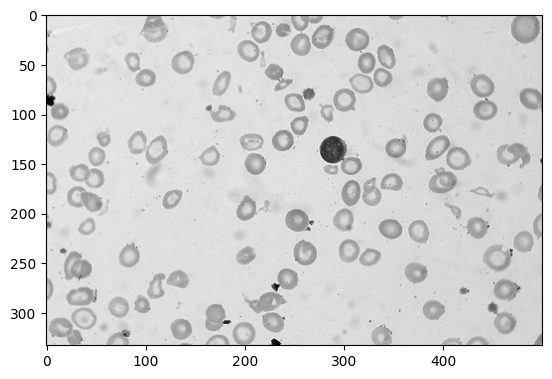

In [7]:
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img, cmap='gray')
plt.show()

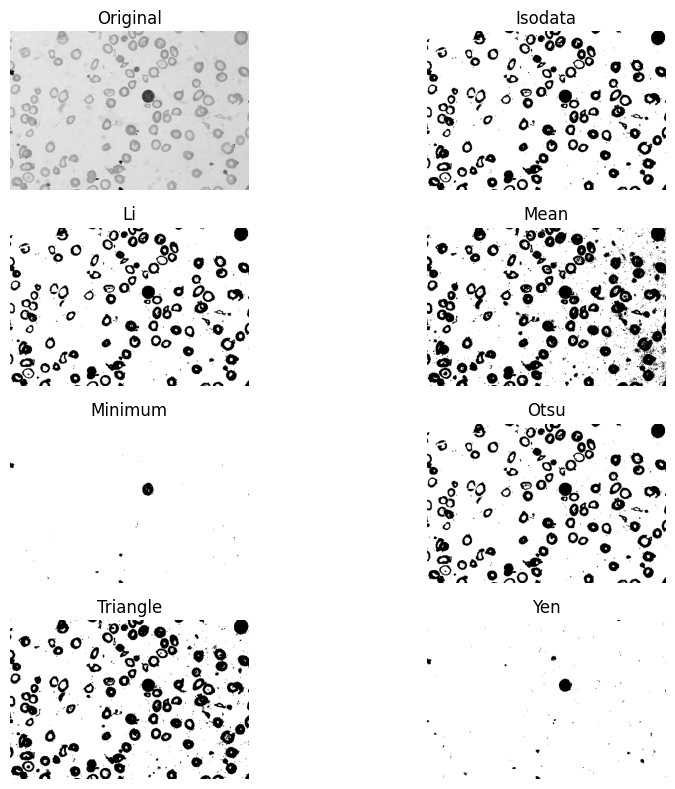

In [8]:
fig, ax = skimage.filters.try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

In [9]:
img.shape

(333, 500)

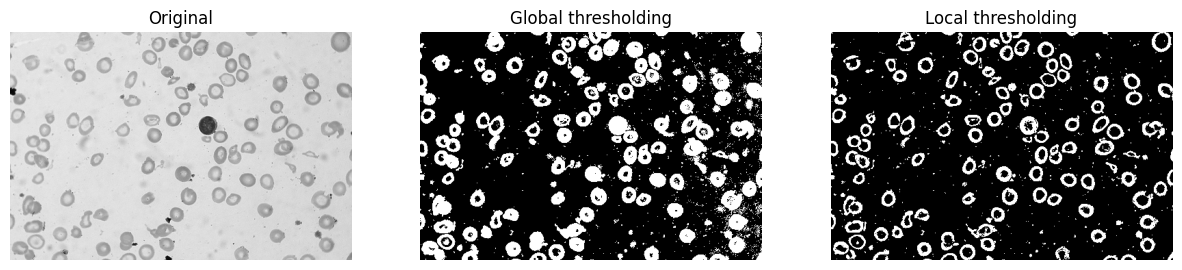

In [277]:
global_thresh = skimage.filters.threshold_mean(img)
binary_global = (img < global_thresh).astype(float)

block_size = 25
local_thresh = skimage.filters.threshold_local(img, block_size, offset=10)
binary_local = (img < local_thresh).astype(float)

fig, axes = plt.subplots(ncols=3, figsize=(15, 10))
ax = axes.ravel()
plt.gray()

ax[0].imshow(img)
ax[0].set_title('Original')

ax[1].imshow(binary_global)
ax[1].set_title('Global thresholding')

ax[2].imshow(binary_local)
ax[2].set_title('Local thresholding')

for a in ax:
    a.axis('off')

plt.show()

In [ ]:
from skimage.color import rgb2hsv, label2rgb
from skimage import data, color, io, img_as_float, feature
from skimage.filters import threshold_otsu, try_all_threshold
from skimage.util import img_as_ubyte, invert

from skimage.transform import hough_circle, hough_circle_peaks, hough_ellipse
from skimage.feature import canny, peak_local_max
from skimage.draw import circle_perimeter, ellipse_perimeter
from skimage.segmentation import clear_border, watershed

from skimage.morphology import erosion, dilation, opening, closing, white_tophat, black_tophat, square
from skimage.morphology import skeletonize, convex_hull_image, medial_axis, thin
from skimage.morphology import disk
from skimage.measure import label, regionprops

import imutils
import cv2

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from collections import deque
from math import sqrt, exp
import numpy as np
import scipy.ndimage as ndi

In [85]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

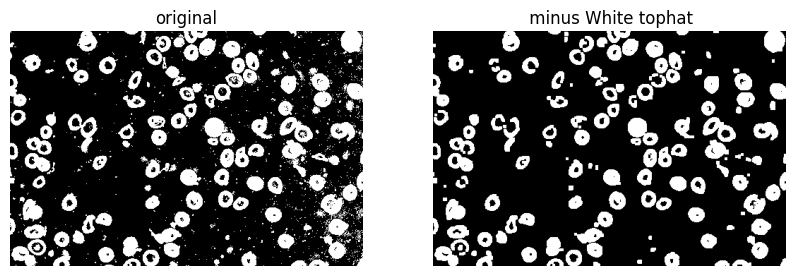

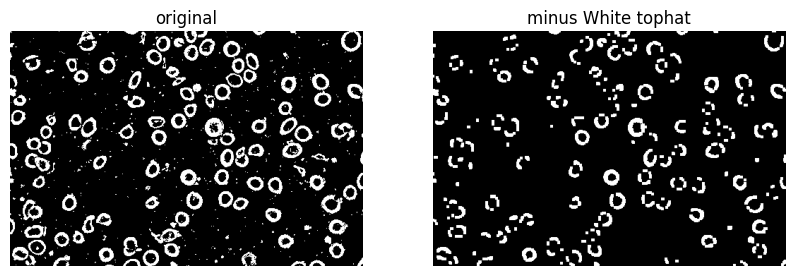

In [315]:
selem = skimage.morphology.square(4)
binary_gl_wh = skimage.morphology.white_tophat(binary_global, selem)
binary_gl_mwh = binary_global - binary_gl_wh
plot_comparison(binary_global, binary_gl_mwh, ' minus White tophat')

selem1 = skimage.morphology.square(4)
binary_loc_wh = skimage.morphology.white_tophat(binary_local, selem1)
binary_loc_mwh = binary_local - binary_loc_wh
plot_comparison(binary_local, binary_loc_mwh, 'minus White tophat')

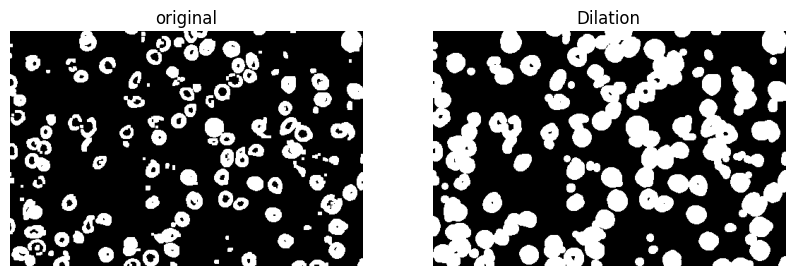

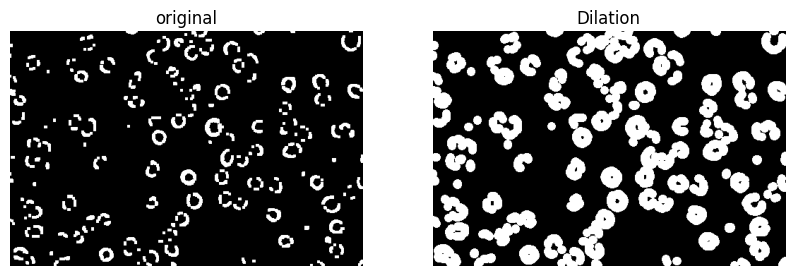

In [316]:
selem = skimage.morphology.disk(3)
binary_gl_dl = skimage.morphology.dilation(binary_gl_mwh, selem)
plot_comparison(binary_gl_mwh, binary_gl_dl, 'Dilation')

selem1 = skimage.morphology.disk(4)
binary_loc_dl = skimage.morphology.dilation(binary_loc_mwh, selem1)
plot_comparison(binary_loc_mwh, binary_loc_dl, 'Dilation')

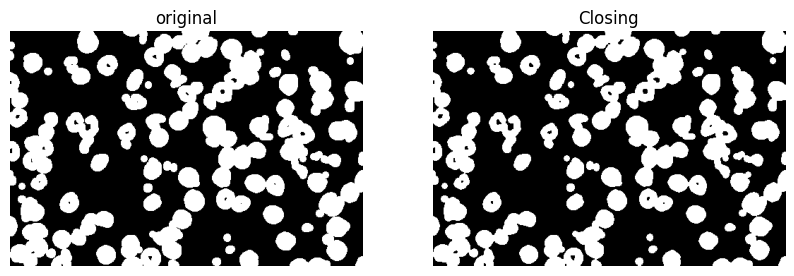

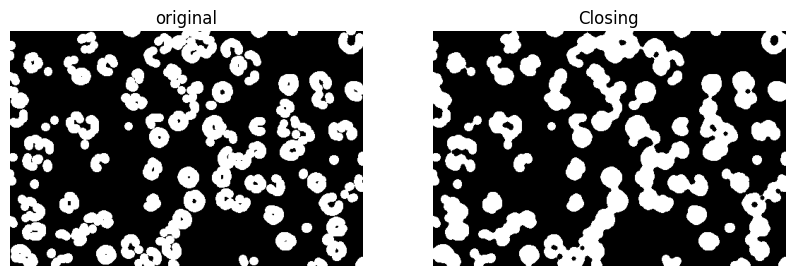

In [317]:
selem = skimage.morphology.square(2)
binary_gl_cl = skimage.morphology.erosion(binary_gl_dl, selem)
plot_comparison(binary_gl_dl, binary_gl_cl, 'Closing')

selem1 = skimage.morphology.disk(3)
binary_loc_cl = skimage.morphology.closing(binary_loc_dl, selem1)
plot_comparison(binary_loc_dl, binary_loc_cl, 'Closing')

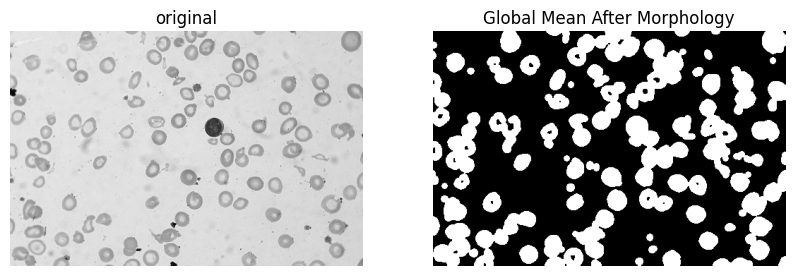

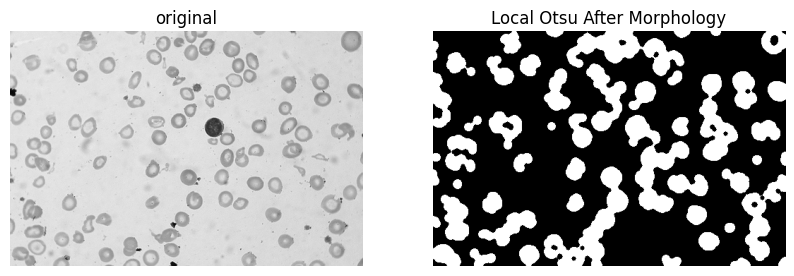

In [318]:
plot_comparison(img, binary_gl_cl, 'Global Mean After Morphology')
plot_comparison(img, binary_loc_cl, 'Local Otsu After Morphology')

Text(0.5, 1.0, 'Loc Canny filter, $\\sigma=1$')

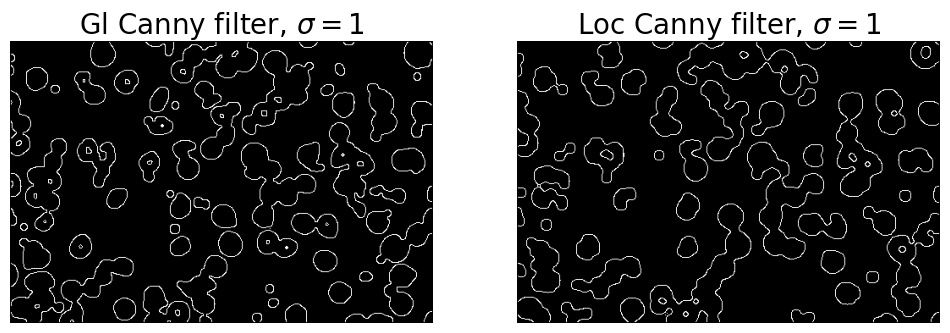

In [321]:
edges_gl = skimage.feature.canny(binary_gl_cl, sigma=1)
edges_loc = skimage.feature.canny(binary_loc_cl, sigma=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].imshow(edges_gl, cmap=plt.cm.gray)
ax[1].imshow(edges_loc, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title(r'Gl Canny filter, $\sigma=1$', fontsize=20)
ax[1].axis('off')
ax[1].set_title(r'Loc Canny filter, $\sigma=1$', fontsize=20)

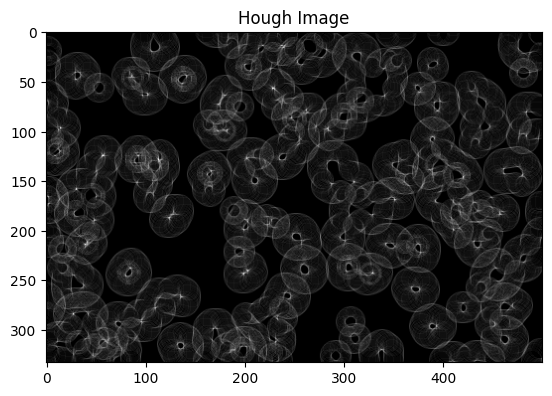

In [322]:
# Detect two radii
hough_radii = np.arange(8, 40, 2)
hough_res_gl = skimage.transform.hough_circle(edges_gl, hough_radii)

hough_radii = np.arange(8, 40, 2)
hough_res_loc = skimage.transform.hough_circle(edges_loc, hough_radii)

plt.imshow(hough_res_gl[1],cmap = 'gray')
plt.title('Hough Image')
plt.show()

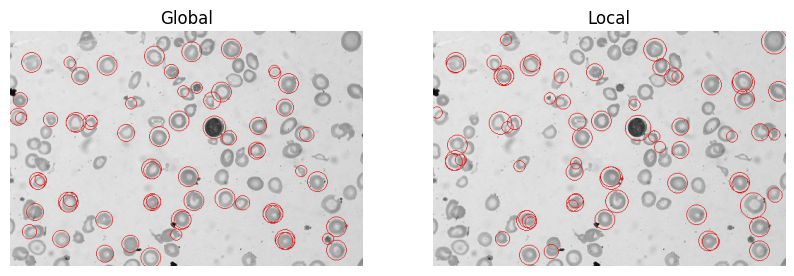

In [323]:
hough_res = [hough_res_gl, hough_res_loc]
names = ['Global', 'Local']
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
for i in range(2):
  accums, cx, cy, radii = skimage.transform.hough_circle_peaks(hough_res[i], hough_radii,
                                            total_num_peaks=70)

  # Draw them
  image = skimage.color.gray2rgb(img).astype('uint8')
  for center_y, center_x, radius in zip(cy, cx, radii):
      circy, circx = skimage.draw.circle_perimeter(center_y, center_x, radius,
                                      shape=image.shape)
      image[circy, circx] = (220, 20, 20)

  ax[i].imshow(image, cmap=plt.cm.gray)
  ax[i].axis('off')
  ax[i].set_title(names[i])

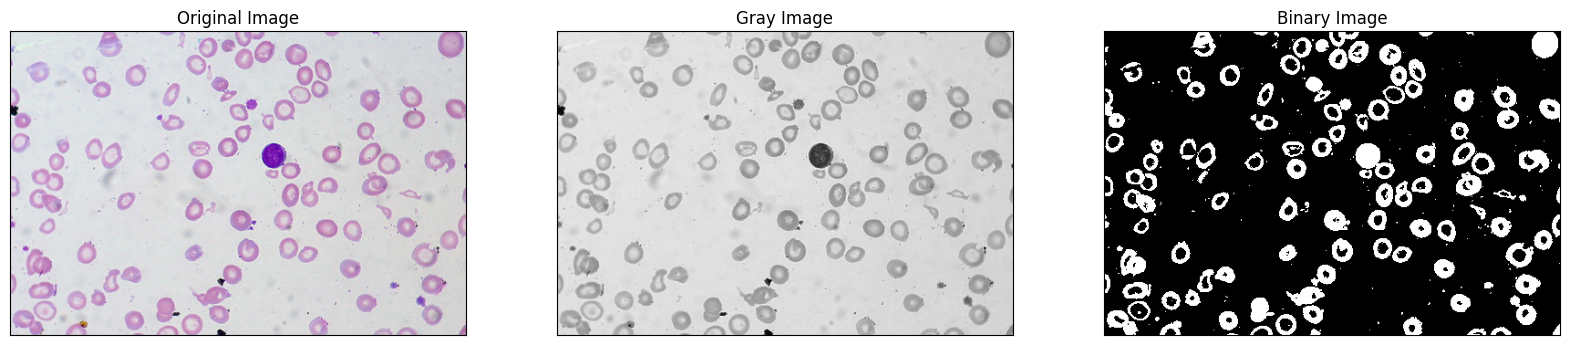

In [329]:
img = cv2.imread('blood.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

fig, ax = plt.subplots(ncols=3, figsize=(20, 8))
plt.subplot(131),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(132),plt.imshow(gray,cmap = 'gray')
plt.title('Gray Image'), plt.xticks([]), plt.yticks([])

plt.subplot(133),plt.imshow(thresh,cmap = 'gray')
plt.title('Binary Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [382]:
# # noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(binary_gl_dl, cv2.MORPH_OPEN,kernel, iterations = 1)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3).astype('uint8')

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening.astype('uint8'), cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform,0.45*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

<ipython-input-383-1d4b6be6d87a>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131),plt.imshow(cv2.cvtColor(sure_fg, cv2.COLOR_BGR2RGB))
<ipython-input-383-1d4b6be6d87a>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(132), plt.imshow(sure_bg,cmap = 'gray')


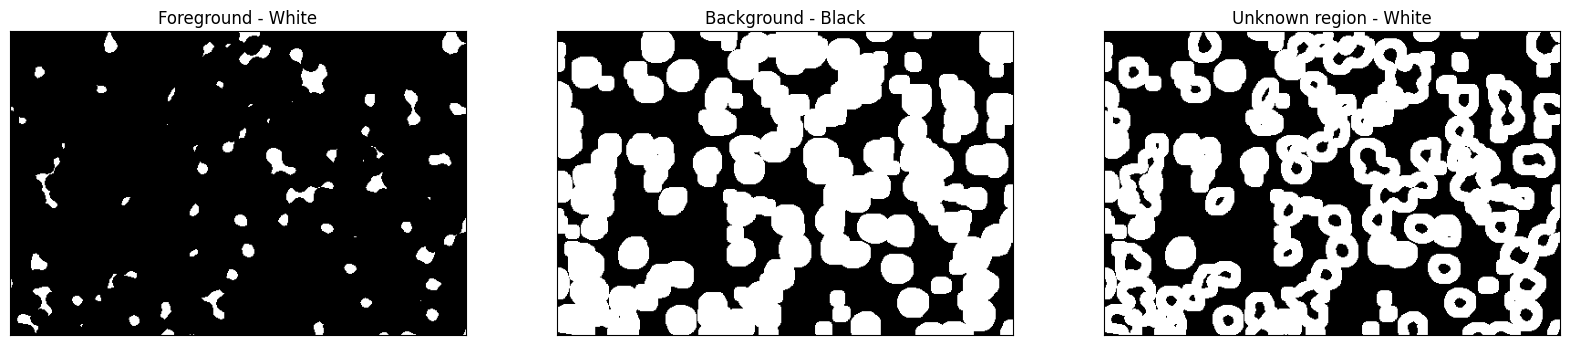

In [383]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
plt.subplot(131),plt.imshow(cv2.cvtColor(sure_fg, cv2.COLOR_BGR2RGB))
plt.title('Foreground - White'), plt.xticks([]), plt.yticks([])

plt.subplot(132), plt.imshow(sure_bg,cmap = 'gray')
plt.title('Background - Black'), plt.xticks([]), plt.yticks([])

plt.subplot(133),plt.imshow(unknown,cmap = 'gray')
plt.title('Unknown region - White'), plt.xticks([]), plt.yticks([])
plt.show()

In [396]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==1] = 0

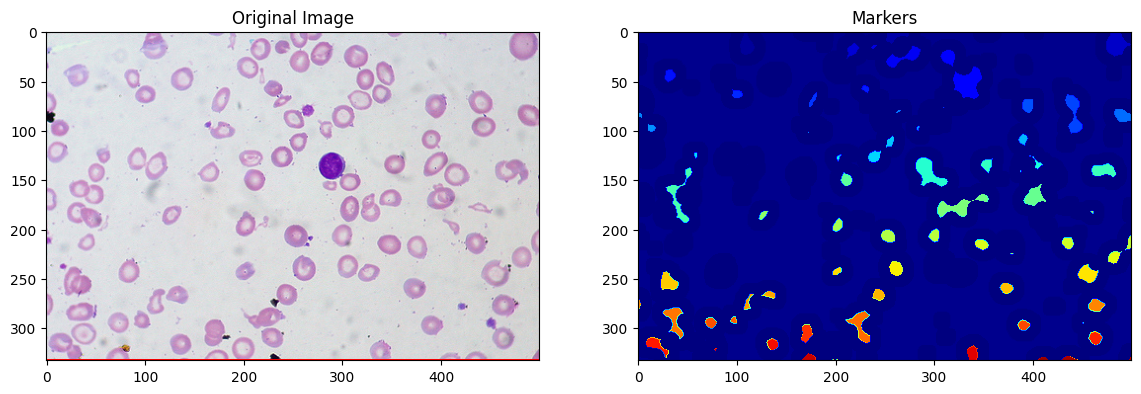

In [398]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 8))
plt.subplot(121),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(122),plt.imshow(markers, cmap="jet")
plt.title('Markers')

plt.show()

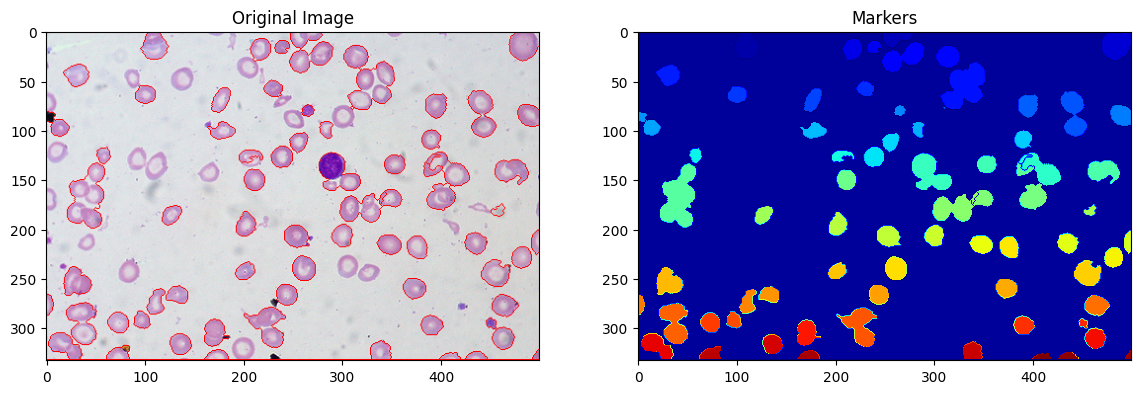

In [399]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [0,0,255]

fig, ax = plt.subplots(ncols=2, figsize=(14, 8))
plt.subplot(121),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(122),plt.imshow(markers, cmap="jet")
plt.title('Markers')

plt.show()